<a href="https://colab.research.google.com/github/jlprieto/sandbox/blob/main/Health_Agregator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and set up

In [1]:
pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110459 sha256=3c759be19a8a7ab638974c91a33e1bbf17a136856dc21d1b8abdc6e9d231eff6
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [57]:
import re
import os
import csv
import json
import time
from datetime import datetime
from google.colab import drive
from google.colab import userdata
from xml.etree.ElementTree import iterparse

import math
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from filterpy.kalman import KalmanFilter

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

from bokeh.plotting import figure, output_notebook, show
from bokeh.models import DatetimeTickFormatter, NumeralTickFormatter
from bokeh.models import Span, Label, BoxAnnotation, Range1d
from bokeh.layouts import gridplot, column

# Enable Bokeh output in the notebook
output_notebook()

_REPROCESS_ = False

In [63]:
_DRIVE_MOUNT_ = userdata.get('_DRIVE_MOUNT_')
if not os.path.exists(_DRIVE_MOUNT_):
  drive.mount(_DRIVE_MOUNT_)

_HEALTH_ROOT_ = userdata.get('_HEALTH_ROOT_')
if not os.path.exists(_HEALTH_ROOT_):
  raise Exception("Health folder not found")

_APPLE_ROOT_ = os.path.join(_HEALTH_ROOT_, 'Apple')
if not os.path.exists(_APPLE_ROOT_):
  raise Exception("APPLE folder not found")

_FITBIT_ROOT_ = os.path.join(_HEALTH_ROOT_, 'Fitbit')
if not os.path.exists(_FITBIT_ROOT_):
  raise Exception("FITBIT folder not found")

_NUTRISENSE_ROOT_ = os.path.join(_HEALTH_ROOT_, 'Nutrisense')
if not os.path.exists(_NUTRISENSE_ROOT_):
  raise Exception("NUTRISENSE folder not found")

_LOSEIT_ROOT_ = os.path.join(_HEALTH_ROOT_, 'LoseIt')
if not os.path.exists(_LOSEIT_ROOT_):
  raise Exception("LoseIt folder not found")

_ABBOTT_ROOT_ = os.path.join(_HEALTH_ROOT_, 'Abbott')
if not os.path.exists(_ABBOTT_ROOT_):
  raise Exception("ABBOTT folder not found")

_PARSED_ROOT_ = os.path.join(_HEALTH_ROOT_, 'Parsed')
if not os.path.exists(_PARSED_ROOT_):
  raise Exception("Destination ('Parsed') folder not found")

/content/drive/My Drive/Health Data/


# Auxiliary functions

In [4]:
def find_latest_path(path: str) -> str:
  """
  Finds the file or latest folder in a directory

  Args:
    path: The path to the directory

  Returns:
    The path to the latest file or folder
  """
  if not os.path.exists(path):
    print("The file does not exist")
    return None
  if not os.path.isdir(path):
    print("The path is not a directory")
    return None

  last_time = 10000000 # sometime in 1970
  latest_path = None
  for path_name in os.listdir(path):
    full_path = os.path.join(path, path_name)
    ctime = os.path.getmtime(full_path)
    if ctime > last_time:
      last_time = ctime
      latest_path = full_path
  return latest_path

In [5]:
def identify_cgm_peaks(cgm = None):
  """
  Identifies peaks in CGM signal and returns the most prominent ones.

  Peaks must be:
  - > 100 mg/dL:
  - have a prominence of 10 mg/dL (prominence=10)
  - be more than 1h apart (distance=12)

  Args:
    cgm: The CGM signal

  Returns:
    A list of peaks
  """
  if cgm.empty: return None
  cgm = cgm.reset_index(drop=True)

  peaks_idx, peak_dict = find_peaks(cgm['glucose'],
                                    height=100,
                                    prominence=10,
                                    distance=12)

  peak_df = pd.DataFrame(peak_dict)
  peak_df['idx'] = list(peaks_idx)
  peak_df['time'] = cgm.loc[list(peaks_idx),'time'].values
  peak_df = peak_df.sort_values(by=['prominences'], ascending=False).copy()
  return peak_df.reset_index(drop=True)

# Parse Abbott Data

In [6]:
last_abbott_path = find_latest_path(_ABBOTT_ROOT_)
if last_abbott_path is None:
  print("No Abbott data found")
else:
  print(f"importing Abbot file: {last_abbott_path}")

importing Abbot file: /content/drive/My Drive/Health Data/Abbott/JavierPrieto_glucose_28-6-2023.csv


In [7]:
abbott_log = pd.read_csv(last_abbott_path, skiprows=1)

# clean up NaNs, 0-values and duplicates
abbott_log = abbott_log.dropna(axis=1, how='all').copy()
abbott_log.drop_duplicates(inplace=True)

# ensure glucose value is numeric and in single column
abbott_log = abbott_log.fillna(0)
if ('Historial de glucosa mg/dL' in abbott_log.columns) and ('Escaneo de glucosa mg/dL' in abbott_log.columns):
  abbott_log['glucose'] = pd.to_numeric(abbott_log['Historial de glucosa mg/dL'], errors='coerce') + \
                          pd.to_numeric(abbott_log['Escaneo de glucosa mg/dL'], errors='coerce')
else:
  raise ValueError(f"I cannot find the glucose columns in {last_abbott_path}")
abbott_log = abbott_log[abbott_log['glucose'] > 1]

# ensure time column is in local time - non-localized and sorted
if 'Sello de tiempo del dispositivo' in abbott_log.columns:
  abbott_log['time'] = pd.to_datetime(abbott_log['Sello de tiempo del dispositivo'],
                                      format='mixed')
else:
  raise ValueError(f"I cannot find the time column in {last_abbott_path}")
abbot_log = abbott_log.sort_values(by=['time']).reset_index(drop=True)

abbott_log = abbott_log[['time', 'glucose']].copy()
abbott_log['device'] = 'FreeStyle Libre'
abbott_log['unit'] = 'mg/dL'

if abbott_log['time'].dt.tz:
  print("WARNING!!!!: Time is unexpectedly localized")

# Parse Nutrisense Data

In [8]:
last_nutri_path = find_latest_path(_NUTRISENSE_ROOT_)
if last_nutri_path is None:
  print("No Nutrisense data found")
else:
  print(f"importing Nutrisense file: {last_nutri_path}")

nutrisense_log = pd.read_csv(last_nutri_path)

importing Nutrisense file: /content/drive/My Drive/Health Data/Nutrisense/20240818_data-export.csv


In [9]:
# Parse the glucose data
nutrisense_glucose = nutrisense_log[nutrisense_log['class'] == 'GlucoseMeasurement'].copy()

# ensure glucose values are numeric
if 'value' in nutrisense_glucose.columns:
  nutrisense_glucose['glucose'] = pd.to_numeric(nutrisense_glucose['value'], errors='coerce')
else:
  raise ValueError(f"I cannot find the glucose column in {last_nutri_path}")

# ensure time column is in local time - non-localized and sorted
if 'occurred_at' in nutrisense_glucose.columns:
  nutrisense_glucose['time'] = pd.to_datetime(nutrisense_glucose['occurred_at'], format='mixed')
else:
  raise ValueError(f"I cannot find the time column in {last_nutri_path}")
nutrisense_glucose = nutrisense_glucose.sort_values(by=['time']).reset_index(drop=True)

if nutrisense_glucose['time'].dt.tz:
  nutrisense_glucose['time'] = nutrisense_glucose['time'].dt.tz_localize(None)

# pair down number of columns
nutrisense_glucose = nutrisense_glucose[['time', 'glucose']].copy()
nutrisense_glucose['device'] = 'Nutrisense'
nutrisense_glucose['unit'] = 'mg/dL'

# clean up NaNs, 0-values and duplicates
nutrisense_glucose = nutrisense_glucose.dropna(axis=1, how='all').copy()
nutrisense_glucose.drop_duplicates(inplace=True)

In [10]:
def parse_nutrition(body):
  """
  Extracts nutritional information from the body of a Nutrisense food log

  Args:
    body: The body of a Nutrisense food log

  Returns:
    A tuple containing the total calories, total fat, total protein, total carbs,
    total saturated fat, total sugar, and total fiber
  """
  if body == []:
    return 0, 0, 0, 0, 0, 0, 0
  else:
    items = json.loads(body)
    total_calories = sum(item['calories'] for item in items)
    total_fat = sum(item['nutrition'].get('total_fat', 0) for item in items)
    total_protein = sum(item['nutrition'].get('protein', 0) for item in items)
    total_carbs = sum(item['nutrition'].get('total_carb', 0) for item in items)
    total_saturated_fat = sum(item['nutrition'].get('saturated_fat', 0) for item in items)
    total_sugar = sum(item['nutrition'].get('sugars', 0) for item in items)
    total_fiber = sum(item['nutrition'].get('fiber', 0) for item in items)

    return total_calories, total_fat, total_protein, total_carbs, total_saturated_fat, total_sugar, total_fiber

In [11]:
nutrisense_meals = nutrisense_log[nutrisense_log['class'] == "Meal"].copy()
nutrisense_meals = nutrisense_meals.drop(['class', 'value', 'length',
                                          'photo_url', 'created_by',
                                          'ended_at', 'started_at',
                                          'updated_at'], axis=1).copy()

# parse nutritional information
nutrition_info = nutrisense_meals['body'].apply(parse_nutrition)
nutrition_df = pd.DataFrame(nutrition_info.tolist(),
                            columns=['Calories', 'Fat',
                                     'Protein', 'Carbs',
                                     'Sat Fat', 'Sugar',
                                     'Fiber'],
                            index=nutrition_info.index)

# assemble compact dataframe with full meal summary
nutrisense_meals['occurred_at'] = pd.to_datetime(nutrisense_meals['occurred_at'])
if nutrisense_meals['occurred_at'].dt.tz:
  nutrisense_meals['occurred_at'] = nutrisense_meals['occurred_at'].dt.tz_localize(None)
nutrisense_compact = pd.DataFrame({
    'Date': nutrisense_meals['occurred_at'].dt.date,
    'Meal': nutrisense_meals['time'],
    'Name': nutrisense_meals['description'],
    'Time': nutrisense_meals['occurred_at'].dt.time,
    'DateTime': nutrisense_meals['occurred_at']
})


# Combine the nutritional data
nutrisense_compact = pd.concat([nutrisense_compact, nutrition_df], axis=1)
nutrisense_compact['True Time'] = True
nutrisense_compact = nutrisense_compact[nutrisense_compact['Calories'] > 10]

# Parse LoseIt Data

In [12]:
last_loseit_path = find_latest_path(_LOSEIT_ROOT_)
if last_loseit_path is None:
  print("No LoseIt data found")
else:
  print(f"importing LoseIt file: {last_loseit_path}")

importing LoseIt file: /content/drive/My Drive/Health Data/LoseIt/20240818_food-logs.csv


In [13]:
loseit_log = pd.read_csv(last_loseit_path)
loseit_log['Date'] = pd.to_datetime(loseit_log['Date'], format='%m/%d/%Y')
loseit_log['Date'] = loseit_log['Date'].dt.date

# remove all items that were deleted
loseit_log = loseit_log[loseit_log['Deleted'] == 0]
# delete irrelevant columns and clean column names
loseit_log = loseit_log.drop(['Icon',
                              'Deleted',
                              'Cholesterol (mg)',
                              'Units',
                              'Quantity',
                              'Sodium (mg)'], axis=1).copy()
loseit_log.rename(columns={'Fat (g)': 'Fat',
                           'Protein (g)': 'Protein',
                           'Carbohydrates (g)': 'Carbs',
                           'Saturated Fat (g)': 'Sat Fat',
                           'Sugars (g)': 'Sugar',
                           'Fiber (g)': 'Fiber'}, inplace=True)

# make sure all values are numeric
numeric_columns = ['Calories', 'Fat',
                   'Protein', 'Carbs',
                   'Sat Fat', 'Sugar', 'Fiber']
loseit_log[numeric_columns] = loseit_log[numeric_columns].apply(pd.to_numeric,
                                                                errors='coerce')
loseit_log.fillna(0, inplace=True)


compact_loseit =  loseit_log.groupby(['Date', 'Meal']).agg({
    'Name': lambda x: '; '.join(x),
    'Calories': 'sum',
    'Fat': 'sum',
    'Protein': 'sum',
    'Carbs': 'sum',
    'Sat Fat': 'sum',
    'Sugar': 'sum',
    'Fiber': 'sum'}).reset_index()

In [14]:
def extract_time(row):
    # Regular expression to find time in format HH:MM AM/PM
    time_match = re.search(r'\b\d{1,2}:\d{2} (AM|PM)\b', row['Name'])

    if time_match:
        return time_match.group(), True
    else:
        # Set default time based on meal type
        if row['Meal'] == 'Breakfast':
          return '8:00 AM', False
        elif row['Meal'] == 'Lunch':
          return '12:00 PM', False
        elif row['Meal'] == 'Dinner':
          return '6:00 PM', False
        elif (row['Meal'] == 'Snacks') | (row['Meal'] == 'Afternoon Snacks'):
          return '4:00 PM', False
        elif row['Meal'] == 'Morning Snacks':
          return '10:00 AM', False
        else:
          print(f'not handling: {row["Meal"]}')
          return None, False

compact_loseit['Time'], compact_loseit['True Time'] = zip(*compact_loseit.apply(extract_time, axis=1))

# Convert the 'Time' column to a proper datetime format with today's date
compact_loseit['Time'] = pd.to_datetime(compact_loseit['Time'],
                                        format='%I:%M %p').dt.time
compact_loseit['DateTime'] = compact_loseit.apply(lambda row: pd.Timestamp.combine(row['Date'], row['Time']), axis=1)

# Assemble and Explore Glucose Data

## Clean up CGM data (assmeble, remove partial days, filter)

In [15]:
# Merge all glucose data and sort by time
glucose_data = pd.concat([abbott_log, nutrisense_glucose])
glucose_data = glucose_data.drop_duplicates(subset=['time'],
                                            keep=False).reset_index(drop=True)
glucose_data = glucose_data.sort_values(by=['time']).reset_index(drop=True)
glucose_data['date'] = glucose_data['time'].dt.date

In [16]:
# Remove the days that are only partially recorded in the CGM data
# (they're first and last day anyways)
grouped = glucose_data.groupby('date')
time_spans = grouped['time'].agg(lambda x: x.max() - x.min())

min_time_span = pd.Timedelta(hours=22)
complete_days = time_spans[time_spans >= min_time_span].index
glucose_data = glucose_data[glucose_data['date'].isin(complete_days)]
glucose_data = glucose_data.sort_values(by=['time']).reset_index(drop=True)

In [17]:
glucose_data['glucose_filtered'] = glucose_data['glucose']
# for day in glucose_data['date'].unique():
#   df = glucose_data[glucose_data['date'] == day].copy()
#   meal_day = compact_loseit[compact_loseit['Date'] == day]

#   kf = KalmanFilter(dim_x=2, dim_z=1)

#   # Define the initial state: [glucose level, glucose velocity]
#   kf.x = np.array([[df['glucose'].iloc[0]], [0]])  # Initial state

#   # State Transition Matrix (F): Model how the state evolves
#   dt = 1.0  # time step
#   kf.F = np.array([[1, dt],
#                   [0, 1]])

#   # Observation Matrix (H): Model how measurements relate to the state
#   kf.H = np.array([[1, 0]])

#   # Process noise covariance (Q): Assumed variance in the process
#   kf.Q = 10 * np.array([[1e-5, 0],
#                       [0, 1e-5]])

#   # Measurement noise covariance (R): Variance in the measurements
#   kf.R = np.array([[0.1]])

#   # Covariance matrix (P)
#   kf.P = np.eye(2) * 0.1

#   # Kalman filtering of the glucose measurements
#   filtered_glucose = []
#   adaptation_factor = 0.1
#   for z in df['glucose']:
#       kf.predict()   # Predict the next state
#       # residual = z - kf.x[0, 0]
#       # kf.Q *= (1 + adaptation_factor * np.abs(residual))
#       kf.update(z)   # Update the state with the new measurement
#       filtered_glucose.append(kf.x[0, 0])

#   glucose_data.loc[df.index, 'glucose_filtered'] = filtered_glucose

## Assemble meal data and summarize CGM per meal

In [18]:
meals = pd.concat([compact_loseit, nutrisense_compact], ignore_index=True)
meals = meals.sort_values(by=['DateTime']).reset_index(drop=True)

## Summarize each day [CGM and days] and join

In [19]:
cgm_daily_stats =  glucose_data.groupby('date')['glucose'].agg(
    mean='mean',
    median='median',
    std='std',
    min='min',
    max='max')
cgm_daily_stats.rename(columns={'mean': 'cgm_mean',
                                'median': 'cgm_median',
                                'std': 'cgm_std',
                                'min': 'cgm_min',
                                'max': 'cgm_max'}, inplace=True)

In [20]:
daily_macros =  meals.groupby('Date')[['Calories',
                                       'Fat',
                                       'Protein',
                                       'Carbs',
                                       'Sat Fat',
                                       'Sugar',
                                       'Fiber']].sum()
daily_macros['calc_calories'] = daily_macros['Fat'] * 9 + \
                                daily_macros['Protein'] * 4 + \
                                daily_macros['Carbs'] * 4
daily_macros['%_fat'] = 9 * daily_macros['Fat'] / daily_macros['calc_calories']
daily_macros['%_carbs'] = 4 * daily_macros['Carbs'] / daily_macros['calc_calories']
daily_macros['%_proteins'] = 4 * daily_macros['Protein'] / daily_macros['calc_calories']
daily_macros['sugar_to_fiber'] = daily_macros['Sugar'] / daily_macros['Fiber']

In [21]:
cgm_and_macros = pd.merge(daily_macros, cgm_daily_stats, left_index=True, right_index=True, how='inner')

# remove days unrealistically low or high on total calories (e.g. < 1000)
cgm_and_macros = cgm_and_macros[cgm_and_macros['Calories'] > 1000].copy()
cgm_and_macros = cgm_and_macros[cgm_and_macros['Calories'] < 4000].copy()

In [22]:
# df = cgm_and_macros.copy()

# # Calculate the correlation matrix
# corr_matrix = df.corr()

# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Matrix')
# plt.show()

# # Find the strongest pairwise correlations
# corr_pairs = corr_matrix.unstack().reset_index()
# corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
# corr_pairs['cross'] = corr_pairs['Variable 1'].apply(lambda x: x in daily_macros.columns) & corr_pairs['Variable 2'].apply(lambda x: x in cgm_daily_stats.columns)
# corr_pairs = corr_pairs[corr_pairs['cross']]
# corr_pairs['sign'] = np.sign(corr_pairs['Correlation'])
# corr_pairs['Correlation'] = np.abs(corr_pairs['Correlation'])
# corr_pairs = corr_pairs.drop_duplicates(subset=['Correlation'])  # Avoid duplicate pairs
# corr_pairs = corr_pairs.sort_values(by='Correlation', ascending=False)  # Sort by absolute correlation

# print("Top Correlations:")
# corr_pairs

In [23]:
# plt.scatter(cgm_and_macros['%_carbs'], cgm_and_macros['cgm_std'])
# plt.xlabel('%_carbs')
# plt.ylabel('CGM_std')
# plt.show()

# plt.scatter(cgm_and_macros['%_fat'], cgm_and_macros['cgm_std'])
# plt.xlabel('%_fat')
# plt.ylabel('CGM_std')
# plt.show()

## Plot CGM and food logs

In [28]:
# Plot all days with good CGM and food log data for visualization
complete_days = set()

# for day in glucose_data['date'].unique():
for day in cgm_and_macros.index.unique():
  # extract loseit meal data for a given day
  meal_day = meals[meals['Date'] == day]
  glucose_day = glucose_data[glucose_data['date'] == day]
  if not meal_day.empty:
    complete_days.add(day)

    # Create a figure
    p = figure(width=600, height=400, x_axis_type='datetime',
                tools=['pan','xwheel_zoom', 'ywheel_zoom'],
                active_scroll='xwheel_zoom', x_axis_location='above')

    # Main CGM line
    p.line(glucose_day['time'], glucose_day['glucose'],
           line_width=2, line_color='gray', line_alpha=0.5)
    # # Main CGM line_filtered
    # p.line(glucose_day['time'], glucose_day['glucose_filtered'],
    #        line_width=2, line_color='black', line_alpha=1)

    # Mean CGM trace
    glucose_mean = np.mean(glucose_day['glucose'])
    mean_span = Span(location=glucose_mean, dimension='width',
                     line_color='red', line_width=1, line_alpha=1)
    p.add_layout(mean_span)

    # CGM Peaks
    peaks_df = identify_cgm_peaks(glucose_day)
    p.scatter(peaks_df['time'], peaks_df['peak_heights'],
              size=6, color='darkblue', alpha=0.7)

    # Meal bands
    for _, row in meal_day.iterrows():
      if row['True Time']:
        color = 'lightgreen'
      else:
        color = 'orange'
      meal_span = Span(location=row['DateTime'], dimension='height',
                       line_color=color, line_width=2, line_alpha=1)
      p.add_layout(meal_span)

      meal_shade = BoxAnnotation(left=row['DateTime'],
                                 right=row['DateTime'] + pd.Timedelta(hours=1),
                                 fill_color=color,
                                 fill_alpha=0.3)
      p.add_layout(meal_shade)

      label = Label(x=row['DateTime'], y=110, text=f"{row['Calories']:.2f}",
                    text_color='black', text_font_size="10pt",
                    angle=90, angle_units="deg",
                    background_fill_color="white",
                    background_fill_alpha=0.7)
      p.add_layout(label)

    # Customize the plot
    p.xaxis.axis_label = "Time"
    p.yaxis.axis_label = "Glucose"
    p.title.text = f"Day: {row['Date']}"
    p.title.align = "center"
    p.title.text_font_size = "20pt"
    p.title.text_font_style = "bold"

    # Show the plot
    show(p)
    print('\n\n')

print(f"There are {len(complete_days)} days: {complete_days}")




There are 44 days: {datetime.date(2022, 12, 13), datetime.date(2022, 12, 17), datetime.date(2024, 6, 19), datetime.date(2024, 6, 21), datetime.date(2023, 1, 18), datetime.date(2022, 4, 19), datetime.date(2024, 6, 29), datetime.date(2024, 6, 20), datetime.date(2024, 8, 17), datetime.date(2022, 4, 18), datetime.date(2024, 6, 25), datetime.date(2024, 7, 17), datetime.date(2024, 7, 22), datetime.date(2022, 12, 12), datetime.date(2024, 6, 22), datetime.date(2024, 8, 12), datetime.date(2024, 7, 18), datetime.date(2023, 1, 17), datetime.date(2024, 8, 5), datetime.date(2022, 4, 16), datetime.date(2024, 8, 6), datetime.date(2024, 8, 13), datetime.date(2024, 8, 2), datetime.date(2022, 4, 20), datetime.date(2022, 7, 14), datetime.date(2024, 8, 4), datetime.date(2024, 8, 7), datetime.date(2022, 12, 14), datetime.date(2022, 12, 15), datetime.date(2024, 8, 8), datetime.date(2024, 6, 18), datetime.date(2024, 7, 19), datetime.date(2024, 7, 21), datetime.date(2024, 6, 24), datetime.date(2024, 7, 16)

## Save meals and glucose data

In [24]:
out_macros_cgm_stats = os.path.join(_PARSED_ROOT_, 'daily_macros_cgm_stats.csv')
print(f"Saving daily CGM stats data in path: {out_macros_cgm_stats}")
cgm_and_macros['Date'] = cgm_and_macros.index
with open(out_macros_cgm_stats, 'w') as f_out:
  cgm_and_macros.to_csv(f_out, index=False, header=True)

out_glucose_path = os.path.join(_PARSED_ROOT_, 'glucose.csv')
print(f"Saving parsed CGM data in path: {out_glucose_path}")
with open(out_glucose_path, 'w') as f_out:
  glucose_data.to_csv(f_out, index=False, header=True)

out_meals_path = os.path.join(_PARSED_ROOT_, 'meals.csv')
print(f"Saving parsed meals in path: {out_meals_path}")
with open(out_meals_path, 'w') as f_out:
  meals.to_csv(f_out, index=False, header=True)

out_daily_macros_path = os.path.join(_PARSED_ROOT_, 'daily_macros.csv')
print(f"Saving daily meals in path: {out_daily_macros_path}")
with open(out_daily_macros_path, 'w') as f_out:
  daily_macros.to_csv(f_out, index=True, header=True)


Saving daily CGM stats data in path: /content/drive/My Drive/Health Data/Parsed/daily_macros_cgm_stats.csv
Saving parsed CGM data in path: /content/drive/My Drive/Health Data/Parsed/glucose.csv
Saving parsed meals in path: /content/drive/My Drive/Health Data/Parsed/meals.csv
Saving daily meals in path: /content/drive/My Drive/Health Data/Parsed/daily_macros.csv


# Parse Apple data

In [25]:
latest_apple_path = find_latest_path(_APPLE_ROOT_)
if latest_apple_path is None:
  print("No Apple data found")

## Generic HKQuantity values in export.html

In [26]:
apple_export_path = os.path.join(latest_apple_path, 'export.xml')
if not os.path.exists(apple_export_path):
  raise Exception(f"No export.xml file found in the Apple folder {latest_apple_path}")

parsed_apple_path = os.path.join(_PARSED_ROOT_, 'apple_export.csv')
print(f"Output path: {parsed_apple_path}")

Output path: /content/drive/My Drive/Health Data/Parsed/apple_export.csv


In [27]:
if _REPROCESS_:
  with open(parsed_apple_path, 'w') as f_out:
    writer = csv.writer(f_out)
    columns = ["startDate", "endDate", "type", "unit", "value", "source"]
    writer.writerow(columns)

    with open(apple_export_path, 'r') as f_in:
      # i = 0
      for _, elem in iterparse(f_in):
        # if i>1000:
        #   break
        # i += 1
        if elem.tag == 'Record':
          row = elem.attrib
          try:
            # print(f'writing: {row}')
            writer.writerow(
                [row.get(u'startDate', ''),
                row.get(u'endDate', ''),
                row.get(u'type', ''),
                row.get(u'unit', ''),
                row.get(u'value', ''),
                row.get(u'sourceName', '')]
            )
          except KeyError as e:
            print(f"KeyError: {e}")

In [28]:
parsed_apple = pd.read_csv(parsed_apple_path)
parsed_apple.drop_duplicates(inplace=True)

<ipython-input-28-63814627676e>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  parsed_apple = pd.read_csv(parsed_apple_path)


## Check types of data

In [29]:
parsed_apple['type'].unique()

array(['HKQuantityTypeIdentifierPeripheralPerfusionIndex',
       'HKQuantityTypeIdentifierDietaryWater',
       'HKQuantityTypeIdentifierBodyMassIndex',
       'HKQuantityTypeIdentifierHeight',
       'HKQuantityTypeIdentifierBodyMass',
       'HKQuantityTypeIdentifierHeartRate',
       'HKQuantityTypeIdentifierOxygenSaturation',
       'HKQuantityTypeIdentifierBloodPressureSystolic',
       'HKQuantityTypeIdentifierBloodPressureDiastolic',
       'HKQuantityTypeIdentifierRespiratoryRate',
       'HKQuantityTypeIdentifierBodyTemperature',
       'HKQuantityTypeIdentifierBodyFatPercentage',
       'HKQuantityTypeIdentifierLeanBodyMass',
       'HKQuantityTypeIdentifierStepCount',
       'HKQuantityTypeIdentifierDistanceWalkingRunning',
       'HKQuantityTypeIdentifierBasalEnergyBurned',
       'HKQuantityTypeIdentifierActiveEnergyBurned',
       'HKQuantityTypeIdentifierFlightsClimbed',
       'HKQuantityTypeIdentifierDietaryFatTotal',
       'HKQuantityTypeIdentifierDietaryFatPolyunsa

## Apple Clinical Records

In [40]:
apple_ehr_path = os.path.join(latest_apple_path, 'clinical-records')
if not os.path.exists(apple_ehr_path):
  raise Exception("No clinical records found")

parsed_apple_blood_labs_path = os.path.join(_PARSED_ROOT_, 'blood_labs_export.csv')
print(f"Output path for blood labs: {parsed_apple_blood_labs_path}")

parsed_apple_ehr_path = os.path.join(_PARSED_ROOT_, 'ehr_export.csv')
print(f"Output path for EHR: {parsed_apple_ehr_path}")

Output path for blood labs: /content/drive/My Drive/Health Data/Parsed/blood_labs_export.csv
Output path for EHR: /content/drive/My Drive/Health Data/Parsed/ehr_export.csv


In [31]:
def process_lab_observation(data: dict) -> dict:
  obs_date = ''
  obs_name = ''
  obs_value = ''
  obs_unit = ''
  low_ref = ''
  high_ref = ''
  code = ''

  obs_date = data.get('effectiveDateTime', '')

  # check if it's a lab or a vital
  category = data.get('category', {}).get('coding', [])
  if len(category) > 0:
    category = category[0].get('code')

  if category == 'laboratory':
    # get rid of any "valueString" observations
    if 'valueString' in data:
      return {}
    # get the name and code
    obs_name = data.get('code', {}).get('text', '')
    obs_code = data.get('code', {}).get('coding', [])
    if len(obs_code) > 0:
      code = obs_code[0].get('code', '')
      if obs_name == '':
        obs_name = obs_code[0].get('display', '')

    # get the value, unit and reference range
    obs_value = data.get('valueQuantity', {}).get('value', '')
    if obs_value == '':
      return {}
    obs_unit = data.get('valueQuantity', {}).get('unit', '')

    reference = data.get('referenceRange', [])
    if len(reference) > 0:
      low_ref = reference[0].get('low', {}).get('value', '')
      high_ref = reference[0].get('high', {}).get('value', '')
  elif category == 'vital-signs':
    # skip vital-signs
    return {}
  else:
    print(f"not processing: {data} from {file_path}")
    return {}

  return {'date': obs_date,
          'lab': obs_name,
          'value': obs_value,
          'unit': obs_unit,
          'low_ref': low_ref,
          'high_ref': high_ref,
          'code': code}

In [34]:
df_labs = pd.DataFrame(columns=['date',
                                'lab',
                                'value',
                                'unit',
                                'low_ref',
                                'high_ref',
                                'code'])
df_allergies = pd.DataFrame(columns=['date',
                                     'substance',
                                     'code'])
df_medications = pd.DataFrame(columns=['date',
                                       'medication',
                                       'code'])
df_immunizations = pd.DataFrame(columns=['date',
                                        'immunization',
                                        'code'])
df_conditions = pd.DataFrame(columns=['date',
                                      'condition',
                                      'code'])

n_observations = 0
n_diagnostic_reports = 0
n_procedure = 0
for file_path in os.listdir(apple_ehr_path):
  if not file_path.endswith('.json'):
    continue
  with open(os.path.join(apple_ehr_path, file_path),'r') as f_in:
    data = json.load(f_in)

  if data.get('resourceType') == 'MedicationStatement':
    med_date = ''
    medication = ''
    code = ''
    if 'contained' in data:
      for item in data.get('contained'):
        if not type(item) == dict:
          raise Exception(f"Unrecognized format for MedicationStatement['contained']: {data.get('contained')}")
        medication = item['code']['text']
        if 'coding' in item['code']:
          code = item['code']['coding'][0]['code']

    if 'medicationCodeableConcept' in data:
      medication = data['medicationCodeableConcept']['text']
      code = data['medicationCodeableConcept']['coding'][0]['code']

    if 'effectivePeriod' in data:
      if 'start' in data['effectivePeriod']:
        med_date = data['effectivePeriod']['start']
      if 'end' in data['effectivePeriod']:
        med_date = data['effectivePeriod']['end']

    df_medications = pd.concat([df_medications,
                                pd.DataFrame({'date': med_date,
                                              'medication': medication,
                                              'code': code},
                                            index=[0])]).reset_index(drop=True)

  elif data.get('resourceType') == 'Immunization':
    vac_date = ''
    immunization = ''
    code = ''
    if 'date' in data:
      vac_date = data['date']
    if 'vaccineCode' in data:
      immunization = data['vaccineCode']['coding'][0]['display']
      code = data['vaccineCode']['coding'][0]['code']
    df_immunizations = pd.concat([df_immunizations,
                                  pd.DataFrame({'date': vac_date,
                                                'immunization': immunization,
                                                'code': code},
                                               index=[0])]).reset_index(drop=True)

  elif data.get('resourceType') == 'MedicationOrder':
    med_date = ''
    medication = ''
    code = ''
    if 'dateWritten' in data:
      med_date = data.get('dateWritten')
    if 'contained' in data:
      for item in data.get('contained'):
        if not type(item) == dict:
          raise Exception(f"Unrecognized format for medicationOrder['contained']: {data.get('contained')}")
        medication = item['code']['text']
        code = item['code']['coding'][0]['code']
    df_medications = pd.concat([df_medications,
                                pd.DataFrame({'date': med_date,
                                              'medication': medication,
                                              'code': code},
                                              index=[0])]).reset_index(drop=True)

  elif data.get('resourceType') == 'AllergyIntolerance':
    allergy_date = ''
    substance = ''
    code = ''
    if 'recordedDate' in data:
      allergy_date = data['recordedDate']
    if 'substance' in data:
      substance = data['substance']['text']
      if 'coding' in data['substance']:
        code = data['substance']['coding'][0]['code']
    df_allergies = pd.concat([df_allergies,
                              pd.DataFrame({'date': allergy_date,
                                            'substance': substance,
                                            'code': code},
                                           index=[0])]).reset_index(drop=True)

  elif data.get('resourceType') == 'Condition':
    cond_date = ''
    condition = ''
    code = ''
    if 'onsetDateTime' in data:
      cond_date = data['onsetDateTime']
    if 'code' in data:
      if 'coding' in data['code']:
        condition = data['code']['coding'][0]['display']
        code = data['code']['coding'][0]['code']
      else:
        condition = data['code']['text']
    df_conditions = pd.concat([df_conditions,
                               pd.DataFrame({'date': cond_date,
                                             'condition': condition,
                                             'code': code},
                                            index=[0])]).reset_index(drop=True)

  elif data.get('resourceType') == 'Patient':
    pass
  elif data.get('resourceType') == 'Procedure':
    pass

  elif data.get('resourceType') == 'Observation':
    lab = process_lab_observation(data)
    if len(lab) > 0:
      df_labs = pd.concat([df_labs,
                           pd.DataFrame(lab, index=[0])]).reset_index(drop=True)

  elif data.get('resourceType') == 'DiagnosticReport':
    report = data.get('contained', [])
    for item in report:
      lab = process_lab_observation(item)
      if len(lab) > 0:
        df_labs = pd.concat([df_labs,
                             pd.DataFrame(lab, index=[0])]).reset_index(drop=True)
  else:
    print(f"not processing: {file_path} with {data.get('resourceType')}")

df_labs['date'] = pd.to_datetime(df_labs['date'], format='mixed')
df_labs['lab'] = df_labs['lab'].str.lower()
df_labs = df_labs.drop_duplicates(subset=['date', 'lab', 'value'])
df_labs = df_labs.sort_values(by=['date', 'lab']).reset_index(drop=True)

<ipython-input-34-78b0a5d858c0>:133: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_labs = pd.concat([df_labs,
<ipython-input-34-78b0a5d858c0>:146: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_labs['date'] = pd.to_datetime(df_labs['date'], format='mixed')


In [36]:
# sandardize lab names
lab_name_patterns = [
    (r'^(basophils|baso|% basophils)(?!.*abs.*)', 'basophils'),
    (r'^(eosinophils|eos|% eosinophils)(?!.*abs.*)', 'eosinophils'),
    (r'^(lymphocytes|lymphs|% lymphocytes)(?!.*abs.*)', 'lymphocytes'),
    (r'^(monocytes|% monocytes)(?!.*abs.*)', 'monocytes'),
    (r'^(neutrophils|%.*neutroph.*)(?!.*abs.*)', 'neutrophils'),
    (r'^(immature granulocytes|%.*immat.*)(?!.*abs.*)', 'immature granulocytes'),
    (r'(^(abs.*)+baso.*|^baso.*abs.*)', 'absolute basophils'),
    (r'(^(abs.*)+eos.*|^eos.*abs.*)', 'absolute eosinophils'),
    (r'(^(abs.*)+neutro.*|^neutro.*abs.*)', 'absolute neutrophils'),
    (r'(^(abs.*)+monocy.*|^monocy.*abs.*)', 'absolute monocytes'),
    (r'(^(abs.*)+lymph.*|^lymph.*abs.*)', 'absolute lymphocites'),
    (r'(^(abs.*)+immat.*|^immat.*abs.*)', 'absolute immature granulocytes'),
    (r'^albumin[^/]', 'albumin'),
    (r'^a/g.*', 'albumin/globulin ratio'),
    (r'^alkaline phosphatase.*', 'alkaline phosphatase'),
    (r'^alt.*', 'alt'),
    (r'^ast.*', 'ast'),
    (r'.*bilirubin.*', 'bilirubin'),
    (r'.*urea nit.*', 'bun'),
    (r'^calcium.*', 'calcium'),
    (r'.*dioxide.*', 'carbon dioxide'),
    (r'^chloride.*', 'chloride'),
    (r'^creatinine.*', 'creatinine'),
    (r'^cholesterol.*', 'cholesterol'),
    (r'.*cortisol.*', 'cortisol'),
    (r'.*creatine kin.*', 'creatine kinase'),
    (r'^globulin.*', 'globulin'),
    (r'^glucose.*', 'glucose'),
    (r'^hdl.*(c\Z|chol.*)', 'hdl'),
    (r'^ldl.*(c\Z|chol.*)', 'ldl'),
    (r'^hematocrit.*', 'hematocrit'),
    (r'^hemoglobin,.*', 'hemoglobin'),
    (r'^hemoglobin a.*', 'hba1c'),
    (r'^magnesium.*', 'magnesium'),
    (r'^mch.*', 'mch'),
    (r'^mchc.*', 'mchc'),
    (r'^mcv.*', 'mcv'),
    (r'^mpv.*', 'mpv'),
    (r'^rdw.*', 'rdw'),
    (r'^nhdlc', 'non hdl cholesterol'),
    (r'.*platelet.*', 'platelets'),
    (r'^potassium.*', 'potassium'),
    (r'.*protein.*tot.*', 'protein, total'),
    (r'^rbc.*', 'red blood cell count'),
    (r'^sodium.*', 'sodium'),
    (r'^testosterone.*', 'testosterone'),
    (r'^triglyc.*', 'triglycerides'),
    (r'^vitamin d.*', 'vitamin d'),
    (r'^wbc.*', 'white blood cell count')
]

unit_patterns = [
    (r'^notyet', '')
]

def standardize_strings(input_str: str, patterns: list) -> str:
  for pattern, replacement in patterns:
    if re.search(pattern, input_str, re.IGNORECASE):
      return replacement
  return input_str

def standardize_names(lab_name:str) -> str:
  return standardize_strings(lab_name, lab_name_patterns)

def standardize_units(unit:str) -> str:
  return standardize_strings(unit, unit_patterns)

df = df_labs.copy().reset_index(drop=True)
df['lab'] = df['lab'].apply(standardize_names)
df['unit'] = df['unit'].apply(standardize_units)
df = df.sort_values(by=['lab']).reset_index(drop=True)

with open(parsed_apple_blood_labs_path, 'w') as f_out:
  df_labs.to_csv(f_out, index=False, header=True)

In [55]:
df_allergies['type'] = 'allergy'
df_allergies = df_allergies.rename(columns={'substance':'description'})
df_allergies['date'] = pd.to_datetime(df_allergies['date'], format='mixed').dt.tz_localize(None)
df_allergies['date'] = df_allergies['date'].dt.date

df_medications['type'] = 'medication'
df_medications = df_medications.rename(columns={'medication':'description'})
# df_medications['date'] = pd.to_datetime(df_medications['date'], format='mixed').dt.tz_localize(None)
# df_medications['date'] = df_medications['date'].dt.date

df_immunizations['type'] = 'immunization'
df_immunizations = df_immunizations.rename(columns={'immunization':'description'})
df_immunizations['date'] = pd.to_datetime(df_immunizations['date'], format='mixed').dt.tz_localize(None)
df_immunizations['date'] = df_immunizations['date'].dt.date

df_conditions['type'] = 'condition'
df_conditions = df_conditions.rename(columns={'condition':'description'})
df_conditions['date'] = pd.to_datetime(df_conditions['date'], format='mixed').dt.tz_localize(None)
df_conditions['date'] = df_conditions['date'].dt.date

df_ehr = pd.concat([df_allergies,
                    df_medications,
                    df_immunizations,
                    df_conditions],
                    ignore_index=True)

with open(parsed_apple_ehr_path, 'w') as f_out:
  df_ehr.to_csv(f_out, index=False, header=True)

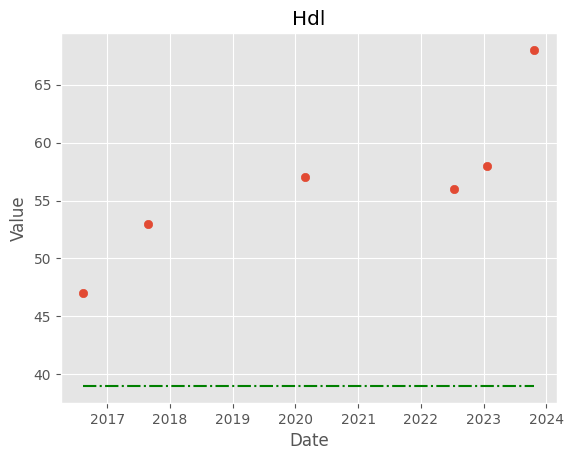

In [39]:
analyte_name = 'hdl' # @param ['albumin', 'red blood cell count', 'glucose', 'ldl', 'hdl', 'white blood cell count', 'platelets', 'triglycerides', 'vitamin b12', 'hba1c', 'vitamin d', 'cholesterol', 'testosterone']
analyte = df[df['lab'] == analyte_name]
analyte = analyte.sort_values(by=['date'])
analyte['low_ref'] = pd.to_numeric(analyte['low_ref'], errors='coerce')
analyte['low_ref'] = analyte['low_ref'].ffill()
analyte['high_ref'] = pd.to_numeric(analyte['high_ref'], errors='coerce')
analyte['high_ref'] = analyte['high_ref'].ffill()
plt.scatter(analyte['date'], analyte['value'])
plt.plot(analyte['date'], analyte['low_ref'], '-.', color='green')
plt.plot(analyte['date'], analyte['high_ref'], '-.', color='green')
plt.title(analyte_name.capitalize())
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

## Apple Wearable Data

# Parse Fitbit Data

In [ ]:
latest_fitbit_path = find_latest_path(_FITBIT_ROOT_)

if latest_fitbit_path is None:
  print("No Fitbit data found")

latest_fitbit_path = os.path.join(latest_fitbit_path, 'Fitbit')

In [ ]:
import glob

all_csv_files = []
for folder in os.listdir(latest_fitbit_path):
  folder_path = os.path.join(latest_fitbit_path, folder)
  if os.path.isdir(folder_path):
    print(f"Processing folder: {folder_path}")
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    all_csv_files.extend(csv_files)
  else:
    print(f"{folder_path} is not a directory")


Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Account Changes
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Fitbit Care or Programs
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Messages
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Discover
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Heart Rate
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Stress Score
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Biometrics
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Fitbit Premium
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Menstrual Health
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Fitbit Friends
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Activity Goal

In [ ]:
all_csv_files

['/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Account Changes/Account_Management_Events_1.csv',
 '/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Messages/COACH Conversations_6bd161f0-eb1b-11ea-bade-871.csv',
 '/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Discover/Coach Content Recommendations.csv',
 '/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Heart Rate/Heart Rate Notifications Alerts.csv',
 '/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Heart Rate/Heart Rate Notifications Profile.csv',
 '/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Stress Score/Stress Score.csv',
 '/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Biometrics/Glucose Target Ranges.csv',
 '/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Fitbit Premium/User Premium Transactions.csv',
 '/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Fitbit Premium/User Premium Subscriptions.csv',
 '/content/drive/My Drive/Health Data

In [ ]:
def process_fitbit_data(file_path: str) -> pd.DataFrame:
  category_mapping ={
      "Daily Readiness Score": "Readiness",
      "sleep_score": "Sleep",
      "Daily SpO2": "SpO2",
      "Respiratory Rate Summary": "Respiration",
      "Daily Respiratory Rate Summary": "Respiration",
      "Daily Heart Rate Variability Summary": "HRV",
      "Computed Temperature": "Stress",
      "Stress Score": "Stress"
  }

# Generate Daily Summaries and other artifacts